---
# Transit Model with GP from GROND in r
---

In [1]:
#IPython notebook
#Author: Riacardo Ramirez Reyes
%matplotlib inline

In [2]:
import pyfits as py
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

/home/reddtea/.local/lib/python3.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [3]:
import george
from george import kernels
import emcee
import corner

# Function

In [4]:
import batman
def transit_lightCurve(time, t0, radius, dist, P, inc):
    params = batman.TransitParams()
    params.t0 = t0                       #time of inferior conjunction
    params.per = P                       #orbital period in days
    params.rp = radius                   #planet radius (in units of stellar radii)
    params.a = dist                      #semi-major axis (in units of stellar radii)
    params.inc = inc                     #orbital inclination (in degrees)
    params.ecc = 0.                      #eccentricity
    params.w = 0.                        #longitude of periastron (in degrees)
    params.u = [0.1, 0.3]                #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       #limb darkening model
    
    m = batman.TransitModel(params, time)    #initializes model
    flux = m.light_curve(params)          #calculates light curve
    
    return (flux)

Neptune_Density = 1638 #kg/m3.
Jupiter_Density = 1326 #kg/m3.
Earth_Density = 5520 #kg/m3.
Earth_radius = 6371000 #m
Jupiter_Radius = 69911000 #m
Jupiter_Mass = 1.898e+27 #kg
Sun_radius = 695700000 #m
au = 149597870700 #m

def RadiusPlanet(density, Mass, StellarRadius): # in jupiter mass and solar radius
    SR = StellarRadius*Sun_radius
    M = Mass*Jupiter_Mass
    r = (3*(M/density) /(4*np.pi))**(1/3)
    return r/SR  # radius in star ratio

def distancePlanet(distance, StellarRadius): # in au, and solar radius
    d = distance*au
    SR = StellarRadius*Sun_radius
    return d/SR  # distance in star ratio

In [5]:
def gaussian(x, sigma):
    coef = -(x*x)/(2*sigma*sigma)
    return 1/np.sqrt(2*np.pi*sigma*sigma) * np.exp(coef)

# Read Data

In [6]:
path =  "/Volumes/SEAGATE1/Reduction/GROND/"

In [7]:
x, y, x_error, y_error = np.load('transit_ground_r.npy')

In [8]:
x.shape

(64,)

# Plot Data

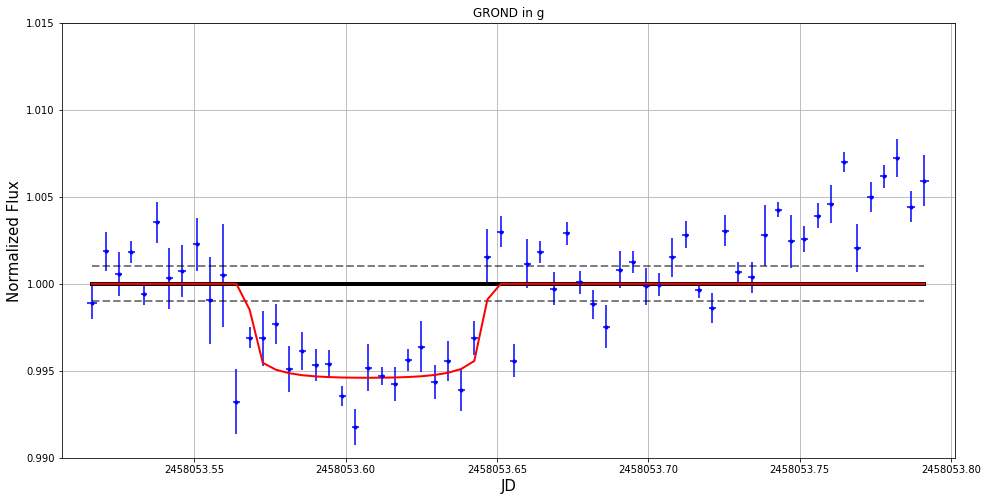

In [9]:
plt.subplots(figsize=(16,8))
plt.grid(True)
plt.xlim( (min(x)-0.01) , (max(x+0.01)))
plt.ylim(0.99, 1.015)

plt.plot((x[0], x[-1]), (1.0 - 0.1/100, 1.0 - 0.1/100), 'k--', linewidth=2, alpha = 0.5)
plt.plot((x[0], x[-1]), (1.0 + 0.1/100 , 1. + 0.1/100), 'k--', linewidth=2, alpha = 0.5)
plt.plot((x[0], x[-1]), (1., 1.), 'k', linewidth=4)

plt.errorbar(x, y, xerr=x_error, yerr=y_error, fmt='b.', alpha=1/1.)

                             #time, t0,     radius,        dist,            P,        inc
y_transit = transit_lightCurve(x, 2456915.6997, 0.0704, 101.1576001138329, 24.73712, 89.912)
plt.plot(x, y_transit, 'r',  linewidth=2)

plt.ylabel('Normalized Flux', fontsize=15)
plt.xlabel('JD', fontsize=15)
plt.title('GROND in g')
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

# Gaussian Process

In [10]:
def give_initial(nwalkers):
    ndim = 4
    T0 = 2456915.70
    r = 0.0704
    k_a = 1.0e-3 # amplitud kernel
    k_r = 3 # radial kernel

    param = []
    for i in range(nwalkers):  
        t1 = T0  + 1e-3*np.random.randn() # Normal distribution 1-1 4-4
        t2 = r   + 1e-4*np.random.randn()
        t6 = k_a + 1*1e-4*np.random.randn()
        t7 = k_r + 1*1e-0*np.random.randn()
        param.append((t1,t2,np.abs(t6),np.abs(t7)))
    return param, ndim

In [11]:
#give random variables
def plus_random_initial(param, nwalkers):
    T0, r, k_a, k_r = param
    t = []
    for i in range(nwalkers):  
        t1 = T0  + 1e-4*np.random.randn() # Normal distribution 1-1 4-4
        t2 = r   + 1e-5*np.random.randn()
        t6 = k_a + 1*1e-4*np.random.randn()
        t7 = k_r + 1*1e-0*np.random.randn()
        t.append((t1,t2, np.abs(t6),np.abs(t7)))
    return t

In [12]:
data = (x, y, y_error)

In [13]:
nwalkers = 50
p0, ndim = give_initial(nwalkers)

In [14]:
def lnprob_gp(param, x, y, yerr):
    lp = lnprior(param)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_gp(param, x, y, yerr)

def lnprior(param):
    T0, r, k_a, k_r = param
    if not (2456915.67 < T0  < 2456915.73 and 0.05 < r  < 0.09 and
        0 < k_a < 5.0e-2 and 0 < k_r < 6.):
        return -np.inf
    
    mu = 0.07 # mean of the Normal prior
    sigma = 0.004 # standard deviation of the Normal prior
    prob_r = np.log(gaussian(r - mu, sigma))
    
    mu = 2456915.70
    sigma =  0.005
    prob_t0 = np.log(gaussian(T0 - mu, sigma))
    prob = prob_t0
    return prob
    
    #return -np.inf

def lnlike_gp(param, x, y, yerr):
    radius = 10.**param[-1]
    gp = george.GP(param[-2] * kernels.Matern32Kernel(radius))
    gp.compute(x, yerr)
    return gp.lnlikelihood(y - Model(param[:-2], x))

def Model(param, x):
    T0, r = param
    transit = transit_lightCurve(x, T0, r, 101.1576001138329, 24.73712, 89.912)
    t = x - x[0]
    return transit


#def Model2(param, x):
#    T0, r, p = param
#    transit = transit_lightCurve(x, T0, r, 101.1576001138329, p, 89.912)
#    t = x - x[0]
#    return transit

In [15]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gp, args=(data))

<Figure size 432x288 with 0 Axes>

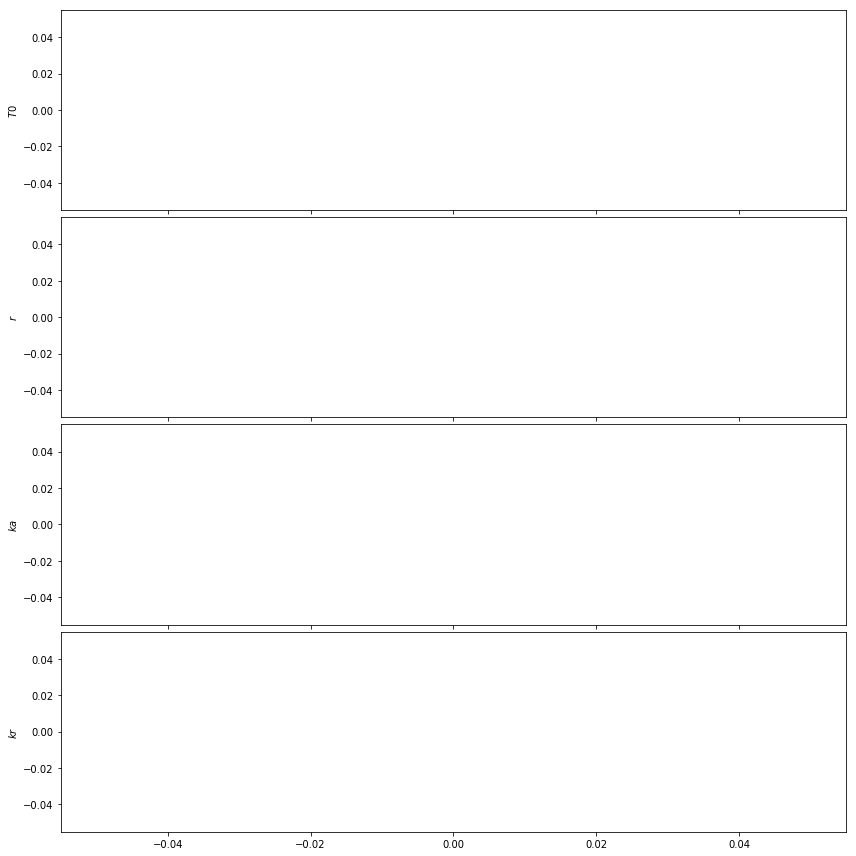

In [16]:
plt.figure('close')
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 12))
import matplotlib.gridspec as gridspec
gs1 = gridspec.GridSpec(4, 1)
gs1.update(wspace=0.025)

axes[0].plot(sampler.chain[:, :, 0].T, color="k", alpha=0.2)
#axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].set_ylabel("$T0$")

axes[1].plot(sampler.chain[:, :, 1].T, color="k", alpha=0.2)
#axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].set_ylabel("$r$")

#axes[2].plot(sampler.chain[:, :, 2].T, color="k", alpha=0.2)
#axes[2].yaxis.set_major_locator(MaxNLocator(5))
#axes[2].set_ylabel("$a$")

#axes[3].plot(sampler.chain[:, :, 3].T, color="k", alpha=0.2)
#axes[3].yaxis.set_major_locator(MaxNLocator(5))
#axes[3].set_ylabel("$b$")

#axes[4].plot(sampler.chain[:, :, 4].T, color="k", alpha=0.2)
#axes[4].yaxis.set_major_locator(MaxNLocator(5))
#axes[4].set_ylabel("$c$")

axes[2].plot(sampler.chain[:, :, 2].T, color="k", alpha=0.2)
#axes[5].yaxis.set_major_locator(MaxNLocator(5))
axes[2].set_ylabel("$k a$")

axes[3].plot(sampler.chain[:, :, 3].T, color="k", alpha=0.2)
#axes[6].yaxis.set_major_locator(MaxNLocator(5))
axes[3].set_ylabel("$k r$")

fig.tight_layout(h_pad=0.0)

In [17]:
print("Running burn-in")
%time p0, lnp, _ = sampler.run_mcmc(p0, 200)

Running burn-in
CPU times: user 4.3 s, sys: 3.56 ms, total: 4.31 s
Wall time: 4.3 s


In [18]:
sampler.lnprobability

array([[168.99200152, 168.99200152, 185.52113769, ..., 263.31761628,
        264.00119372, 268.55330491],
       [224.02247352, 221.62807105, 221.62807105, ..., 268.35086205,
        268.46113806, 268.46113806],
       [166.85892625, 166.85892625, 176.95553436, ..., 266.90303911,
        267.37122467, 267.37122467],
       ...,
       [248.8327855 , 248.8327855 , 248.98365599, ..., 267.81962186,
        267.81962186, 268.37037621],
       [154.2694263 , 153.92429185, 153.92429185, ..., 269.54877192,
        269.22249427, 269.22249427],
       [185.42593205, 188.70509746, 188.70509746, ..., 268.67436944,
        269.78135073, 269.67482145]])

In [19]:
sampler.reset()
print("Running second burn-in")
p = p0[np.argmax(lnp)]
p0 = plus_random_initial(p, nwalkers)
%time p0, _, _ = sampler.run_mcmc(p0, 1000)

Running second burn-in
CPU times: user 21.2 s, sys: 3.84 ms, total: 21.2 s
Wall time: 21.2 s


<Figure size 432x288 with 0 Axes>

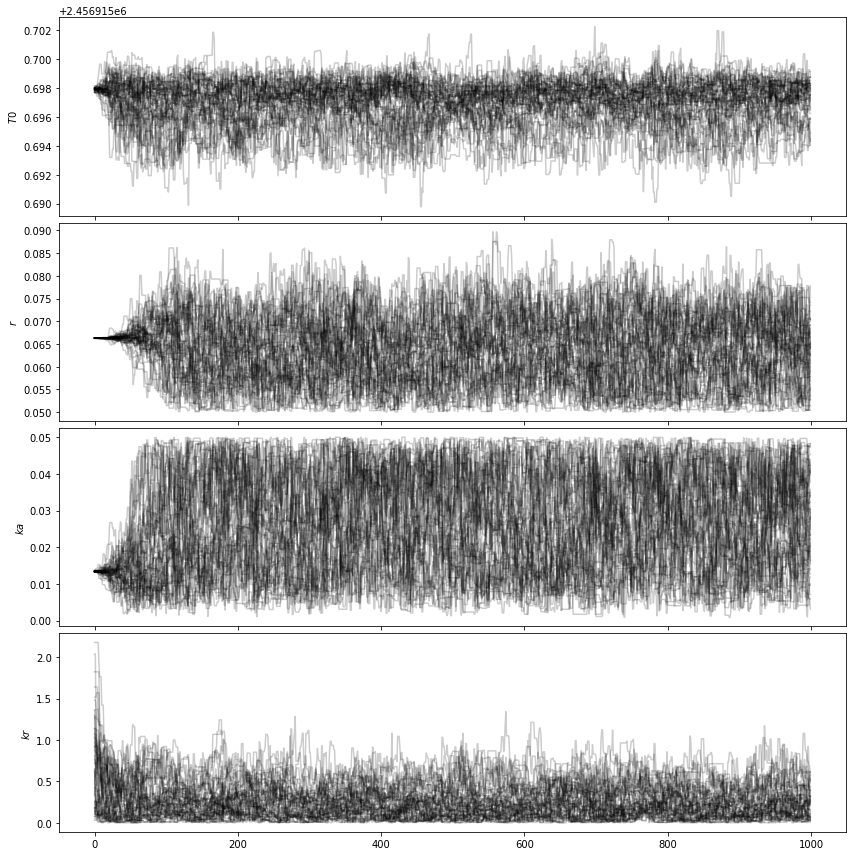

In [20]:
plt.figure('close')
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 12))
import matplotlib.gridspec as gridspec
gs1 = gridspec.GridSpec(4, 1)
gs1.update(wspace=0.025)

axes[0].plot(sampler.chain[:, :, 0].T, color="k", alpha=0.2)
#axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].set_ylabel("$T0$")

axes[1].plot(sampler.chain[:, :, 1].T, color="k", alpha=0.2)
#axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].set_ylabel("$r$")

#axes[2].plot(sampler.chain[:, :, 2].T, color="k", alpha=0.2)
#axes[2].yaxis.set_major_locator(MaxNLocator(5))
#axes[2].set_ylabel("$a$")

#axes[3].plot(sampler.chain[:, :, 3].T, color="k", alpha=0.2)
#axes[3].yaxis.set_major_locator(MaxNLocator(5))
#axes[3].set_ylabel("$b$")

#axes[4].plot(sampler.chain[:, :, 4].T, color="k", alpha=0.2)
#axes[4].yaxis.set_major_locator(MaxNLocator(5))
#axes[4].set_ylabel("$c$")

axes[2].plot(sampler.chain[:, :, 2].T, color="k", alpha=0.2)
#axes[5].yaxis.set_major_locator(MaxNLocator(5))
axes[2].set_ylabel("$k a$")

axes[3].plot(sampler.chain[:, :, 3].T, color="k", alpha=0.2)
#axes[6].yaxis.set_major_locator(MaxNLocator(5))
axes[3].set_ylabel("$k r$")

fig.tight_layout(h_pad=0.0)

In [21]:
samples = sampler.chain[:, -1000:, :].reshape((-1, ndim))

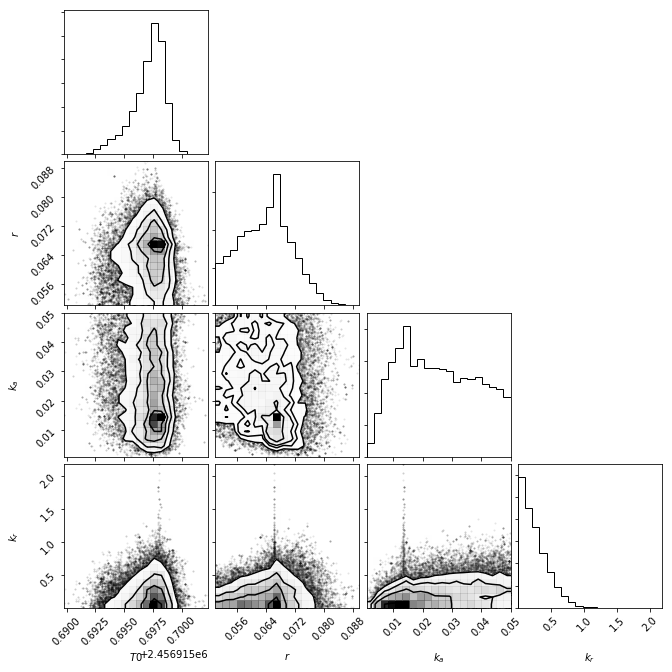

In [22]:
#fig = corner.corner(samples ,labels=["$T0$", "$r$", "$a$", "$b$", "$c$", "$k_a$", "$k_r$"])
fig = corner.corner(samples ,labels=["$T0$", "$r$", "$k_a$", "$k_r$"])

In [23]:
T0_f, r_f, ka_f, kr_f = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print('T0 = ' + str(T0_f))
print('r = ' + str(r_f))
print('k a = ' + str(ka_f))
print('k r = ' + str(kr_f))

T0 = (2456915.6973720705, 0.000984464306384325, 0.0017203171737492085)
r = (0.06443799046211934, 0.006479693903542583, 0.008364444098895946)
k a = (0.024326659930969913, 0.01636756094072552, 0.013060693755877366)
k r = (0.20776729249530748, 0.24569286346111804, 0.149493613614236)


In [24]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }

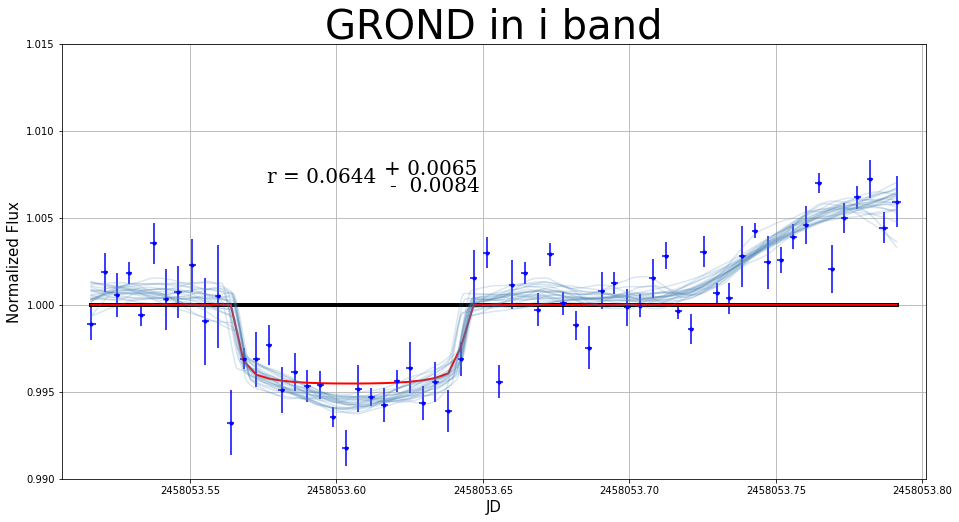

In [25]:
plt.subplots(figsize=(16,8))
plt.grid(True)
plt.xlim( (min(x)-0.01) , (max(x+0.01)))
plt.ylim(0.99, 1.015)

#std = np.std(y[-5:])

#plt.plot((x[0], x[-1]), (1.0 - std, 1.0 - std), 'k--', linewidth=2, alpha = 0.5)
#plt.plot((x[0], x[-1]), (1.0 + std , 1. + std), 'k--', linewidth=2, alpha = 0.5)
plt.plot((x[0], x[-1]), (1., 1.), 'k', linewidth=4)

plt.errorbar(x, y, xerr=x_error, yerr=y_error, fmt='b.', alpha=1/1.)

y_transit = transit_lightCurve(x, T0_f[0], r_f[0], 101.1576001138329, 24.73712, 89.912)
plt.plot(x, y_transit, 'r',  linewidth=2)

#temp = x-x[0]
#y_model = y_transit + a_f[0] + b_f[0]*temp + c_f[0]*temp*temp
#plt.plot(x, y_model, 'g',  linewidth=2, alpha = 0.5)

plt.ylabel('Normalized Flux', fontsize=15)
plt.xlabel('JD', fontsize=15)
plt.title('GROND in i band', fontsize=40)
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.subplots_adjust(left=0.15)

#plt.text(x[0]+0.2, 1.005, r'STD = '+str(np.around(std, decimals=4)), fontdict=font)

r_t = str(np.around(r_f[0], decimals=4))
r_tp = str(np.around(r_f[1], decimals=4))
r_tm = str(np.around(r_f[2], decimals=4))
plt.text(x[0]+0.06, 1.007, 'r = '+ r_t , fontdict=font)
plt.text(x[0]+0.10, 1.0075, '+ '+ r_tp, fontdict=font)
plt.text(x[0]+0.102, 1.0065, '-  '+ r_tm, fontdict=font)

x2 = np.linspace(min(x), max(x), 1000)
if True:
    for s in samples[np.random.randint(len(samples), size=24)]:
        radius = 10.**s[-1]
        gp = george.GP(s[-2]* kernels.Matern32Kernel(radius))
        #gp = george.GP(0.2* kernels.Matern32Kernel(radius))
        gp.compute(x, y_error)
        m = gp.sample_conditional(y - Model(s[:-2], x), x2) + Model(s[:-2], x2)
        plt.plot(x2, m, '-', color="#4682b4", alpha=0.2)


In [35]:
print ( r'r = '+r_t+' + '+r_tp +' - '+r_tm)
print(len(x), len(y))
print(len(gp.sample_conditional(y - Model(s[:-2], x), x2)), len(Model(s[:-2], x2)))

r = 0.06444 + 0.00648 - 0.00836
64 64
1000 1000


<ErrorbarContainer object of 3 artists>

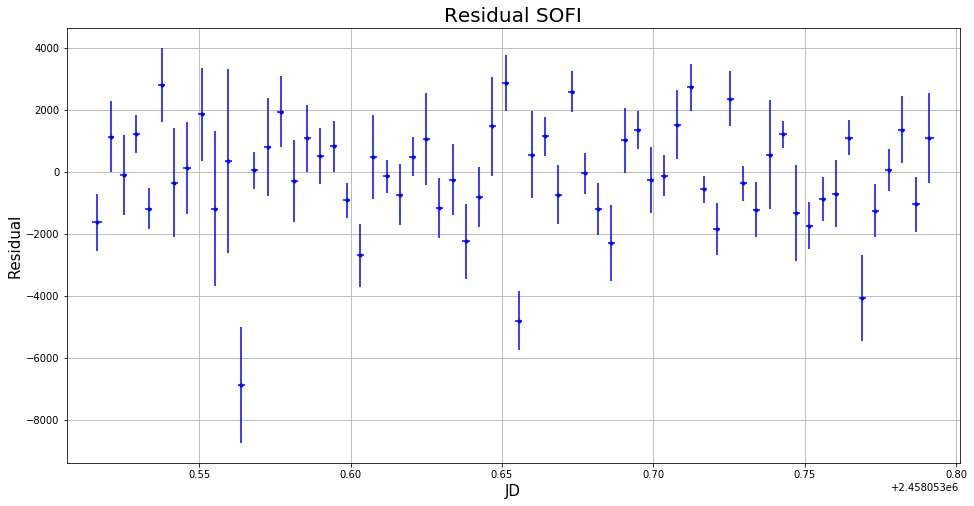

In [27]:
plt.subplots(figsize=(16,8))
plt.grid(True)
plt.xlim( (min(x)-0.01) , (max(x+0.01)))
plt.ylabel('Residual', fontsize=15)
plt.xlabel('JD', fontsize=15)
plt.title('Residual SOFI', fontsize=20)

# time
radius = 10.**kr_f[0]
kernel= ka_f[0] * kernels.Matern32Kernel(radius)

gp = george.GP(kernel)
gp.compute(x, y_error)

nsamples = y - Model((T0_f[0], r_f[0]), x)
gp_model = gp.sample_conditional(nsamples, x2)
m = gp_model + Model((T0_f[0], r_f[0]), x2)

m_f = np.interp(x, x2, m)


plt.errorbar(x, (y - m_f)*1000000, xerr=x_error, yerr=y_error*1000000, fmt='b.', alpha=1/1.)

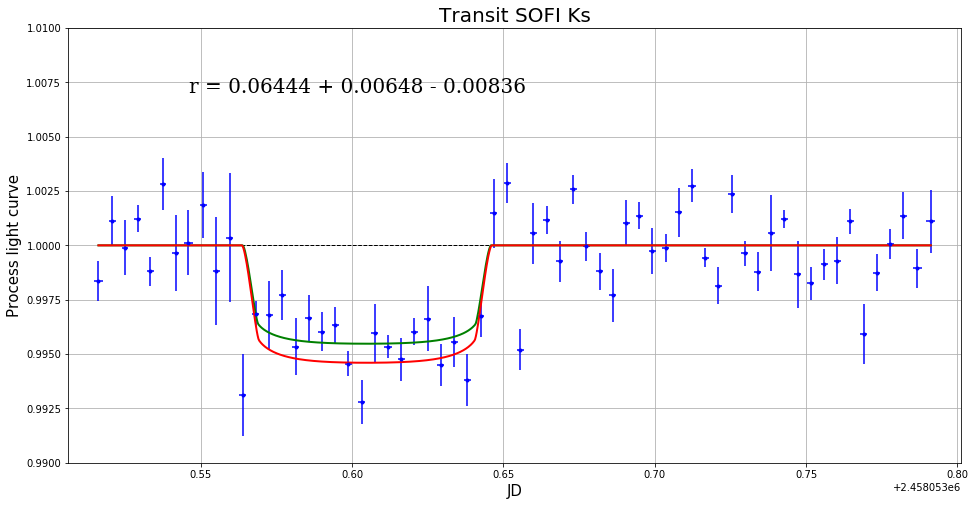

In [28]:
plt.subplots(figsize=(16,8))
plt.grid(True)
plt.xlim( (min(x)-0.01) , (max(x+0.01)))
plt.ylabel('Process light curve', fontsize=15)
plt.xlabel('JD', fontsize=15)
plt.title('Transit SOFI Ks', fontsize=20)
plt.ylim(0.99, 1.01)

r_t = str(np.around(r_f[0], decimals=5))
r_tp = str(np.around(r_f[1], decimals=5))
r_tm = str(np.around(r_f[2], decimals=5))
plt.plot((x[0], x[-1]), (1., 1.), 'k--', linewidth=1)
plt.text(x[0]+0.03, 1.007, r'r = '+r_t+' + '+r_tp +' - '+r_tm, fontdict=font)


m_f = np.interp(x, x2, m)
y_transit_f = transit_lightCurve(x2, T0_f[0], r_f[0], 101.1576001138329, 24.73712, 89.912)

plt.errorbar(x, (y - m_f + (y_transit)), xerr=x_error, yerr=y_error, fmt='b.', alpha=1/1.)
plt.plot(x2, y_transit_f, 'g',  linewidth=2)

y_transit_f = transit_lightCurve(x2, T0_f[0], 0.0704, 101.1576001138329, 24.73712, 89.912)
plt.plot(x2, y_transit_f, 'r',  linewidth=2)

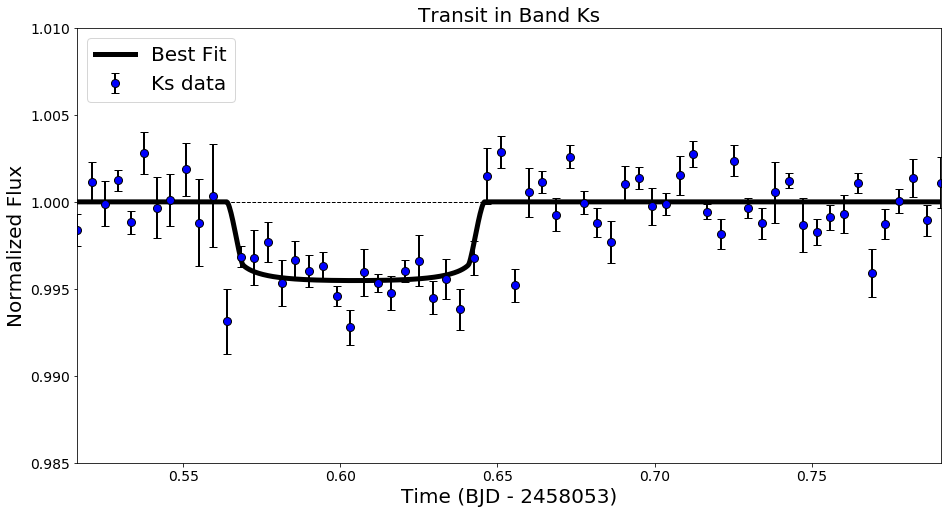

In [29]:
plt.subplots(figsize=(16,8))
plt.grid(False)
plt.xlim( (min(x)-0.01) , (max(x+0.01)))
plt.ylabel('Normalized Flux', fontsize=20)
plt.yticks(fontsize=14)
plt.xlabel('Time (BJD - 2458053)', fontsize=20)
plt.xticks(fontsize=14)
plt.title('Transit in Band Ks', fontsize=20)
plt.ylim(0.985, 1.010)
plt.xlim(x[0]-2458053, x[-1]-2458053)

r_t = str(np.around(r_f[0], decimals=5))
r_tp = str(np.around(r_f[1], decimals=5))
r_tm = str(np.around(r_f[2], decimals=5))
plt.plot((x[0]-2458053, x[-1]-2458053), (1., 1.), 'k--', linewidth=1)

m_f = np.interp(x, x2, m)
y_transit_f = transit_lightCurve(x2, T0_f[0], r_f[0], 101.1576001138329, 24.73712, 89.912)


plt.errorbar(x -2458053, (y - m_f + (y_transit)), yerr=y_error, fmt='k,', label='Ks data',
             marker='o', mfc='blue', mec='k', ms=8, mew=1, elinewidth= 2, capsize=4)

plt.plot(x2 -2458053, y_transit_f, 'k',  linewidth=5, label='Best Fit')


ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.subplots_adjust(left=0.15)
plt.legend(loc=2, fontsize=20)

NameError: name 'jd' is not defined

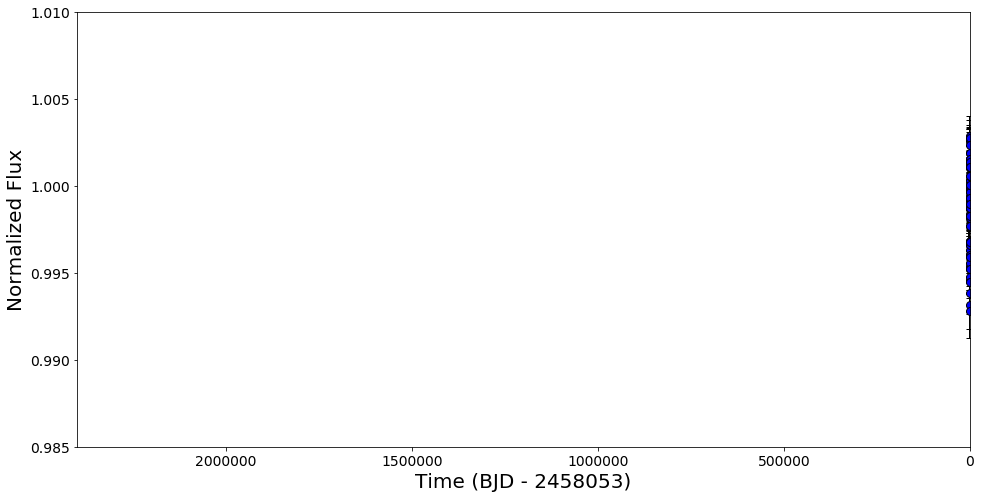

In [30]:
plt.subplots(figsize=(16,8))
plt.grid(False)
plt.xlim( (min(x)-0.01) , (max(x+0.01)))
plt.ylabel('Normalized Flux', fontsize=20)
plt.yticks(fontsize=14)
plt.xlabel('Time (BJD - 2458053)', fontsize=20)
plt.xticks(fontsize=14)
#plt.title('Transit in Band Ks', fontsize=20)
plt.ylim(0.985, 1.010)
plt.xlim(x[0]-58053, 58053.17-58053)

r_t = str(np.around(r_f[0], decimals=5))
r_tp = str(np.around(r_f[1], decimals=5))
r_tm = str(np.around(r_f[2], decimals=5))
plt.plot((x[0]-2458053, x[-1]-2458053), (1., 1.), 'k--', linewidth=1)

m_f = np.interp(x, x2, m)
y_transit_f = transit_lightCurve(x2, T0_f[0], r_f[0], 101.1576001138329, 24.73712, 89.912)


plt.errorbar(x -2458053, (y - m_f + (y_transit)), yerr=y_error, fmt='k,', label='Ks data',
             marker='o', mfc='blue', mec='k', ms=8, mew=1, elinewidth= 2, capsize=4)

plt.plot(x2 -2458053, y_transit_f, 'k',  linewidth=5, label='Best Fit')


m_f_2 = np.interp(jd, x2, m)
y_transit_f = transit_lightCurve(jd, T0_f[0], r_f[0], 101.1576001138329, 24.73712, 89.912)


plt.plot(jd -58053, (div - m_f_2 + (y_transit_f)), '.', alpha = 0.2)




ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.subplots_adjust(left=0.15)
plt.legend(loc=2, fontsize=20)

In [ ]:
np.save('GROND_r_finalPlotsdata', (x -2458053, (y - m_f + (y_transit)), y_error))